In [1]:
import os, sys
import numpy as np

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import matplotlib.pyplot as plt
from matplotlib import cm

import copy
import scipy.stats

from plotting import plot_utils, load_fits, summary_plots
from utils import roi_utils, default_paths
from analyze_features import load_feature_stats

plot_utils.set_all_font_sizes(16)

#### Load everything to plot
This is an analysis correlating each voxel's beta weights with semantic category labels (no encoding model used here, just raw data)

In [2]:
subjects = np.arange(1,9)

n_subjects = len(subjects)

fitting_type = 'semantic_discrim_raw_trnval_all'

out = [load_fits.load_fit_results(ss, fitting_type,n_from_end=nf,verbose=False) \
           for [ss,nf] in zip(subjects,[1,1,1,0,0,0,0,0])]        

n_discrim_types = len(out[0]['discrim_type_list'])
assert(len(out[0]['axes_to_do_partial'])==n_discrim_types)
signed_names = out[0]['discrim_type_list']

full_corrs = []
partial_corrs = []
tvals = []
pvals = []
noise_ceilings = []
nsamp = []
nsamp_partialcorrs = []

nc_thresh = 0.01
min_samp = 5

# flipping the signs of each axis to make the plots easier to understand
which_axes_negate = [0,1,2,3,4]

for si, ss in enumerate(subjects):
  
    c_full = copy.deepcopy(out[si]['sem_corr_each_axis']).T
    c_full[which_axes_negate,:] *= (-1)
    
    full_corrs += [c_full];
      
    c_partial = copy.deepcopy(out[si]['sem_partial_corrs']).T
    c_partial[which_axes_negate,:] *= (-1)
    
    partial_corrs += [c_partial];
    
    # sample size used for the partial correlations - only uses trials where every label 
    # is unambiguously defined, for all axes.
    ns = out[si]['sem_partial_n_samp']
    min_samp_each = [np.nanmin(ns[:,ii,:]) for ii in range(n_discrim_types)]
    print(min_samp_each)
    nsamp_partialcorrs += [ns]
         
    t = copy.deepcopy(out[si]['sem_discrim_each_axis']).T
    t[which_axes_negate,:] *= (-1)
    
    tvals += [t];

    # compute the p-value for each t-statistic, based on the degrees of freedom
    # (number of samples)
    # sample size here is larger than for the partial corrs, because the trials only have to have a 
    # valid label for one axis, not all
    ns = out[si]['n_sem_samp_each_axis']
    min_samp_each = [np.nanmin(ns[:,ii,:]) for ii in range(n_discrim_types)]
    print(min_samp_each)
    nsamp += [ns]
    
    df = ns[:,:,0]+ns[:,:,1]-2
    # two-tailed test, multiply by 2
    p = scipy.stats.t.sf(np.abs(t), df.T)*2

    pvals  += [p];

    noise_ceilings += [summary_plots.get_noise_ceiling(out[si])]

[1.0, 11.0, 90.0, 214.0, 240.0]
[5.0, 221.0, 418.0, 344.0, 3007.0]
[1.0, 7.0, 79.0, 187.0, 256.0]
[9.0, 211.0, 436.0, 296.0, 2946.0]
[1.0, 9.0, 66.0, 198.0, 233.0]
[3.0, 190.0, 337.0, 285.0, 2760.0]
[1.0, 7.0, 82.0, 176.0, 229.0]
[4.0, 4.0, 192.0, 411.0, 272.0]
[1.0, 10.0, 73.0, 209.0, 252.0]
[4.0, 4.0, 216.0, 399.0, 297.0]
[1.0, 8.0, 77.0, 180.0, 238.0]
[4.0, 4.0, 221.0, 380.0, 291.0]
[1.0, 6.0, 73.0, 178.0, 229.0]
[5.0, 5.0, 213.0, 394.0, 290.0]
[1.0, 4.0, 66.0, 183.0, 213.0]
[3.0, 3.0, 223.0, 358.0, 288.0]


In [3]:
from analyze_fits import sem_voxel_groups
sem_groups, sem_group_names = sem_voxel_groups.get_sem_voxel_groups()
n_sem_groups = len(sem_group_names)

In [8]:
np.sum(sem_groups[0], axis=0)

array([500, 500, 500, 500, 500, 500, 500, 500])

#### Define ROIs

In [4]:
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

#### Plot the average partial correlation coefficient for each axis
Average over voxels in each ROI, then over subjects

0.9366197183098591
0.9506120726044744
0.911904404779761
0.903744880046811
0.9629469590580102
0.9602010699133001
0.9406980273141123
0.8032412442897542


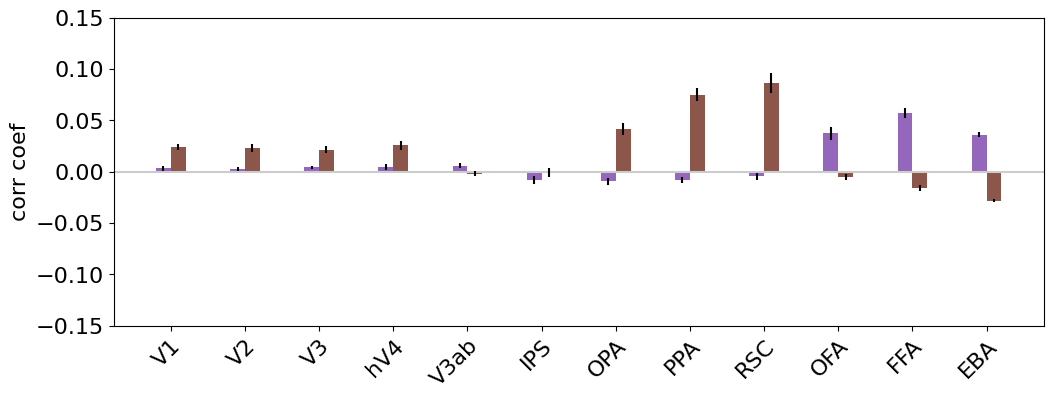

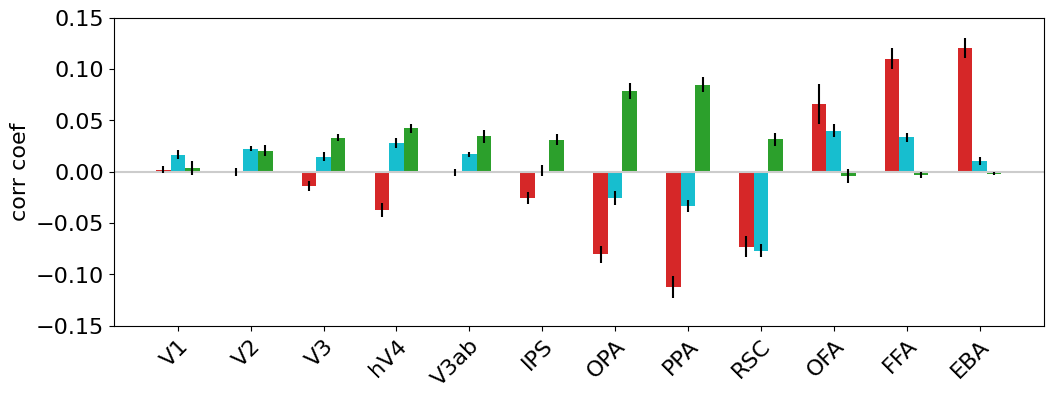

In [7]:
colors = cm.tab10(np.linspace(0,1,10))[[4,5,3,9,2],:]
roi_mean_vals = np.zeros((n_rois, n_discrim_types, n_subjects))

for si in range(n_subjects):

    nc = noise_ceilings[si]
    vox2use = nc>nc_thresh
    vals = partial_corrs[si]
    
    # ignore voxels where there weren't enough trials to reliably compute semantic selectivity
    # (this is based on the voxel's pRF and how many images had each label for that pRF)
    bad_nsamp = (nsamp_partialcorrs[si]<min_samp) | np.isnan(nsamp_partialcorrs[si])
    vox_exclude = np.any(np.any(bad_nsamp, axis=2), axis=1)
    
    vox2use = vox2use & ~(vox_exclude)
    print(np.mean(vox2use))
    
    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for axes_plot in [[0,1],[2,3,4]]:
 
    bw = 0.2;
    space = (1 - (bw*len(axes_plot)))/2
                  
    fh = plot_utils.plot_multi_bars(mean_data=mean_vals[:,axes_plot], err_data=sem_vals[:,axes_plot], \
                                    # point_data = np.moveaxis(roi_mean_vals[:,axes_plot,:], [0,1,2], [1,2,0]), \
                                    colors=colors[axes_plot,:], space=space, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-0.15, 0.15], horizontal_line_pos=0,\
                legend_labels=np.array(signed_names)[axes_plot], \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(12,4))

# fn2save = os.path.join(default_paths.fig_path, 'Semantic_selectivity_signed_ROIavg.pdf')
# plt.savefig(fn2save)

#### Use PyCortex to make surface plots

In [5]:
from plotting import pycortex_plot_utils
volumes = {}
out = [load_fits.load_fit_results(ss, fitting_type,n_from_end=0,verbose=False) for ss in subjects]

mm=0;

for si, ss in enumerate(subjects):

    nc = noise_ceilings[si]
    vox2plot = nc>nc_thresh
 
    bad_nsamp = (nsamp_partialcorrs[si]<min_samp) | np.isnan(nsamp_partialcorrs[si])
    vox_exclude = np.any(np.any(bad_nsamp, axis=2), axis=1)
    
    vox2plot = vox2plot & ~(vox_exclude)
    
    vals_partial = copy.deepcopy(partial_corrs[si])
   
    names = []
    maps = []
    cmaps = []
    mins = []
    maxes = []
            
    for dim in range(n_discrim_types):
        
        names += ['S%d: %s partial'%(ss, signed_names[dim])]
        maps += [vals_partial[dim,:]]
        cmaps += ['RdBu']
        mins += [-0.5]
        maxes += [0.5]
        
    for gg in range(n_sem_groups):
        
        names += ['S%d: top %s vox'%(ss, sem_group_names[gg])]
        maps += [sem_groups[si][:,gg].astype(float)]
        cmaps += ['Blues']
        mins += [-0.1]
        maxes += [1.1]
      
    voxel_mask = out[si]['voxel_mask']
    nii_shape = out[si]['brain_nii_shape']
    mask_3d = np.reshape(voxel_mask, nii_shape, order='C')

    vol_ss = pycortex_plot_utils.maps_to_volumes(ss, maps, names, \
                         cmaps=cmaps, mins=mins, maxes=maxes, \
                         voxel_mask=voxel_mask, nii_shape=nii_shape, mask_3d=mask_3d, \
                         vox2plot=vox2plot)

    volumes.update(vol_ss)
    

In [6]:
viewer = pycortex_plot_utils.plot_with_overlays(volumes, title='Semantic selectivity partial corrs', \
                                                port = 64447, \
                                                labels_on=False, recache=False, \
                                                overlay_type = 'overlays')

using overlays from /user_data/mmhender/pycortex_db/subj01/overlays.svg
navigate browser to: 127.0.0.1:64447
Started server on port 64447


#### Plot the raw correlation coefficents for each axis
compared to the partial corrs, they are similar but some are larger in magnitude

0.9727935961090283
0.9717180244829042
0.9428028598570072
0.9338209479227618
0.9760181484282164
0.978278915329275
0.9658270106221548
0.8464215792908418


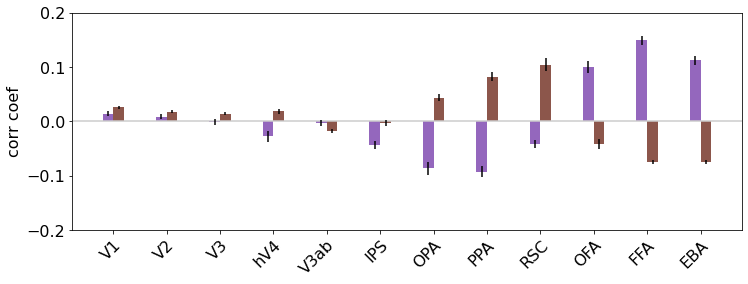

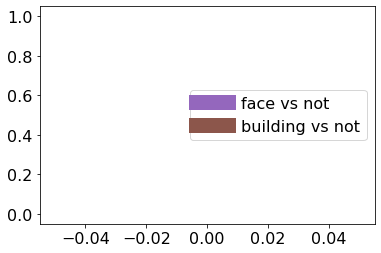

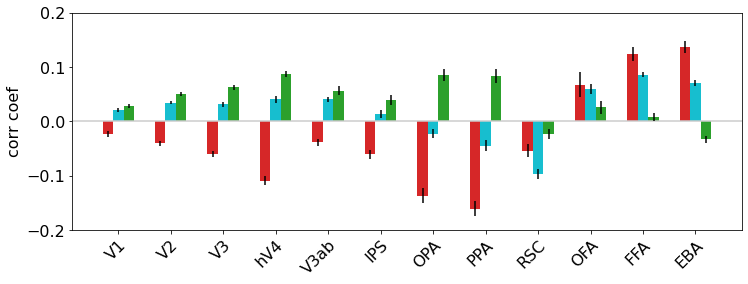

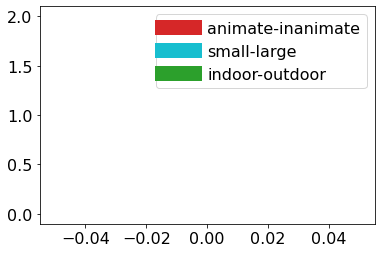

In [28]:
colors = cm.tab10(np.linspace(0,1,10))[[4,5,3,9,2],:]
roi_mean_vals = np.zeros((n_rois, n_discrim_types, n_subjects))

for si in range(n_subjects):

    nc = noise_ceilings[si]
    vox2use = nc>nc_thresh
    vals = full_corrs[si]

    # ignore voxels where there weren't enough trials to reliably compute semantic selectivity
    # (this is based on the voxel's pRF and how many images had each label for that pRF)
    bad_nsamp = (nsamp[si]<min_samp) | np.isnan(nsamp[si])
    vox_exclude = np.any(np.any(bad_nsamp, axis=2), axis=1)
    
    vox2use = vox2use & ~(vox_exclude)
    print(np.mean(vox2use))
    
    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for axes_plot in [[0,1],[2,3,4]]:
 
    bw = 0.2;
    space = (1 - (bw*len(axes_plot)))/2
                  
    fh = plot_utils.plot_multi_bars(mean_data=mean_vals[:,axes_plot], err_data=sem_vals[:,axes_plot], \
                                    # point_data = np.moveaxis(roi_mean_vals[:,axes_plot,:], [0,1,2], [1,2,0]), \
                                    colors=colors[axes_plot,:], space=space, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-0.2, 0.2], horizontal_line_pos=0,\
                legend_labels=np.array(signed_names)[axes_plot], \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(12,4))

# fn2save = os.path.join(default_paths.fig_path, 'Semantic_selectivity_signed_ROIavg.pdf')
# plt.savefig(fn2save)

#### Plot t-statistic 
alternative to the correlation coefficient (this is what p-values are based on)

0.9727935961090283
0.9717180244829042
0.9428028598570072
0.9338209479227618
0.9760181484282164
0.978278915329275
0.9658270106221548
0.8464215792908418


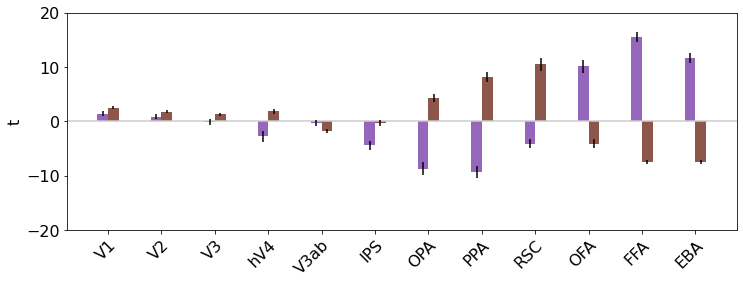

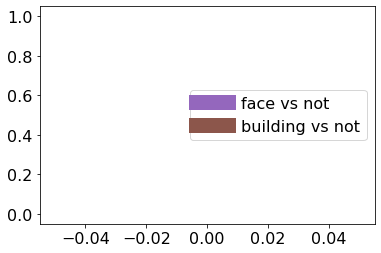

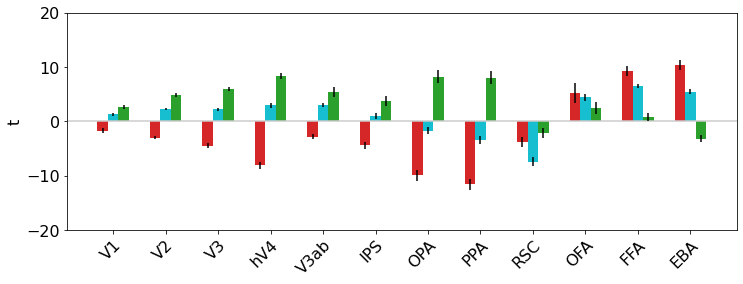

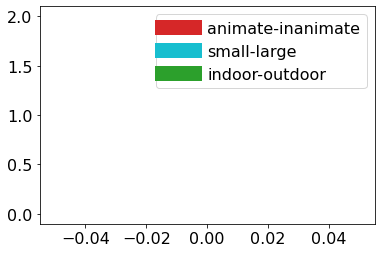

In [30]:
colors = cm.tab10(np.linspace(0,1,10))[[4,5,3,9,2],:]
roi_mean_vals = np.zeros((n_rois, n_discrim_types, n_subjects))

for si in range(n_subjects):

    nc = noise_ceilings[si]
    vox2use = nc>nc_thresh
    vals = tvals[si]

    # ignore voxels where there weren't enough trials to reliably compute semantic selectivity
    # (this is based on the voxel's pRF and how many images had each label for that pRF)
    bad_nsamp = (nsamp[si]<min_samp) | np.isnan(nsamp[si])
    vox_exclude = np.any(np.any(bad_nsamp, axis=2), axis=1)
    
    vox2use = vox2use & ~(vox_exclude)
    print(np.mean(vox2use))
    
    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for axes_plot in [[0,1],[2,3,4]]:
 
    bw = 0.2;
    space = (1 - (bw*len(axes_plot)))/2
                  
    fh = plot_utils.plot_multi_bars(mean_data=mean_vals[:,axes_plot], err_data=sem_vals[:,axes_plot], \
                                    # point_data = np.moveaxis(roi_mean_vals[:,axes_plot,:], [0,1,2], [1,2,0]), \
                                    colors=colors[axes_plot,:], space=space, \
                xticklabels=roi_names, ylabel='t', \
                ylim=[-20,20], horizontal_line_pos=0,\
                legend_labels=np.array(signed_names)[axes_plot], \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(12,4))

# fn2save = os.path.join(default_paths.fig_path, 'Semantic_selectivity_signed_ROIavg.pdf')
# plt.savefig(fn2save)